In [3]:
import numpy as np
import pandas as pd
import time

## MNIST handwritten dataset

In [15]:
from sklearn.datasets import fetch_openml
# load MNIST dataset
mnist = fetch_openml('mnist_784')
X = mnist.data / 255.0
y = mnist.target

print(X.shape)
print(y.shape)
print(y.value_counts())

data = X.copy()
data['label'] = y
X = None
y = None
print('done')

(70000, 784)
(70000,)
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: class, dtype: int64
done


#T-SNE

##Gaussian Distribution for HIGH-Dimension data

calculate distance

In [4]:
def cal_dis(X):
  '''
    X - data matrix(n rows * d dimensions)
    calculate the Euclidean distance
    Using Matrix Operations to speed up

    return D - square distance matrix
    e.g. D[i][j] - the square distance between i and j   (xi - xj)**2
  '''

  sum_X = np.sum(np.square(X), 1)
  D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
  return D

equation (1).svg

In [5]:
def calc_P_and_entropy(D=np.array([]), beta=1.0):
  '''
    D - the square distance
    beta - 1 / 2 * (sigma**2)

    return P - Gaussian distribution matrix (like D)
        log_perplexity - for calculating the gradient
  '''

  # P - p[i][j]
  P = np.exp(-D.copy() * beta)
  sumP = np.sum(P)

  # try to change beta to make log_perplexity be closer with H
  # H = -sum(p j|i) * logp j|i
  log_perplexity = np.log(sumP) + beta * (np.sum(D * P) / sumP)
  P = P/sumP
  return P, log_perplexity

In [6]:
def b_search_beta(D, init_beta, tol=1e-5, perplexity=30.0, max_iter=50):
  """
    Performs a binary search to get P-values in such a way that each
    conditional Gaussian has the same perplexity.

    D - distance
    tol - finish search if the difference less than the value of tol
    perplexity - hyperparameter

    return P - Optimized probability matrix
        beta - Optimized beta

  """

  beta_max = np.inf
  beta_min = -np.inf
  beta = init_beta

  P, log_entropy = calc_P_and_entropy(D, beta)
  diff_log_entropy = log_entropy - np.log(perplexity)

  iter = 0
  # entropy is inversely related to beta
  while np.abs(diff_log_entropy)>tol and iter<max_iter:
    if diff_log_entropy>0:
      beta_min = beta
      if beta_max == np.inf or beta_max == -np.inf:
        beta = beta*2
      else:
        beta = (beta+beta_max)/2.

    else:
      beta_max = beta
      if beta_min == -np.inf or beta_min == -np.inf:
        beta = beta/2
      else:
        beta = (beta + beta_min)/2.

    # compute the entrop again
    P, log_entropy=calc_P_and_entropy(D, beta)
    diff_log_entropy = log_entropy - np.log(perplexity)
    iter = iter+1

  return P, beta

Compute the joint possibility

equation (2).svg

In [7]:
def p_joint(distances, perplexity=30):
  '''
    X - data matrix(n rows * d dimensions)
    perplexity - hyperparameter

    return P_join the joint possibility matrix
  '''
  N = distances.shape[0]
  beta = np.ones((N, 1))

  p_conditional = np.zeros([N,N])
  # Search for the optimal sigma(beta) for each sample point
  # and calculate the corresponding P
  for i in range(N):
    if i % 500 ==0:
      print("Compute joint P for %d points" % (i))
    # Remove datapoints on the diagonal
    Di = np.delete(distances[i,:],i)
    # binary search to get beta
    # let the diff log-entropy be minimized
    P, beta[i] = b_search_beta(Di, beta[i], perplexity=perplexity)

    # fill up '0' at the deleted position
    p_conditional[i] = np.insert(P,i,0)

  # Make it symmetric
  P_join = p_conditional + p_conditional.T
  P_join = P_join / np.sum(P_join)

  # show the value of optimized beta
  print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))

  return P_join

##students t(Cauchy)  distribution for LOW-Dimension data

fb4fd37d4f9ead6783db00336e3a44f9cefff318.svg

In [8]:
def q_t_distribution(Y):
  N = np.shape(Y)[0]
  sum_Y = np.sum(np.square(Y), 1)
  num = -2. * np.dot(Y, Y.T)
  num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
  num[range(N), range(N)] = 0.
  Q = num / np.sum(num)
  Q = np.maximum(Q, 1e-12)
  # return numerators to compute the gradient
  return Q, num

##PCA

In [9]:
def pca(X=np.array([]), no_dims=50):
  """
    Runs PCA on the NxD array X in order to reduce its dimensionality to
    no_dims dimensions.
  """

  print("Preprocessing the data using PCA...")
  (n, d) = X.shape
  X = X - np.tile(np.mean(X, 0), (n, 1))
  (l, M) = np.linalg.eig(np.dot(X.T, X))
  Y = np.dot(X, M[:, 0:no_dims])
  return Y

##T-SNE

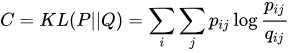

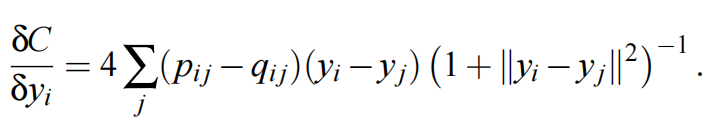

In [10]:
def tsne_s1(distance_pre, no_dims=2, initial_dims=50, perplexity=30.0, eta=500, e_exaggeration=2, tolerance=1e-3, max_iter=1000):
  """
    Runs t-SNE on the dataset in the NxD array X to reduce its
    dimensionality to no_dims dimensions. The syntaxis of the function is
    `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    eta - learning rate
  """

  # Check inputs
  if isinstance(no_dims, float):
    print("Error: array X should have type float.")
    return -1
  if round(no_dims) != no_dims:
    print("Error: number of dimensions should be an integer.")
    return -1

  t_P = time.time()
  # Compute joint P-values
  P = p_joint(distance_pre, perplexity)
  P = P * e_exaggeration									# Trick: early exaggeration
  P = np.maximum(P, 1e-12)
  print("-----pairwise similarity done. It costs %f seconds-----" % (time.time()-t_P))

  #Initialize randomly for low-dimensional data
  n = distance_pre.shape[0]
  Y = np.random.randn(n, no_dims)

  #hyperparameters of gradient descent with momentum
  initial_momentum = 0.5
  final_momentum = 0.8

  min_gain = 0.01
  dY = np.zeros((n, no_dims)) # gradient
  iY = np.zeros((n, no_dims)) # delta Y
  gains = np.ones((n, no_dims)) # the length of steps

  # early stopping
  patience_counter = 0
  best_error = 99999
  patience_limit = 200

  t_Q = time.time()
  # Run iterations
  for iter in range(max_iter):

    # Compute pairwise affinities
    Q, num= q_t_distribution(Y)

    # Compute gradient
    PQ = P - Q
    for i in range(n):
      dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

    # Perform the update
    if iter < 20:
      momentum = initial_momentum
    else:
      momentum = final_momentum

    # If dY and iY are in the same direction, gains+=2;
    # otherwise, gains *= 0.8
    # i.e. If the direction of gradient descent remains the same it increases the gains and vice versa.
    gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
          (gains * 0.8) * ((dY > 0.) == (iY > 0.))
    gains[gains < min_gain] = min_gain
    iY = momentum * iY - eta * (gains * dY)
    Y = Y + iY

    # Ensure that the centre of the distribution remains at the origin in each iteration
    Y = Y - np.tile(np.mean(Y, 0), (n, 1))

    C = np.sum(P * np.log(P / Q))

    # Check for early stopping
    if best_error-C < tolerance:
      patience_counter += 1
    else:
      patience_counter = 0

    if C < best_error:
      best_error = C

    if patience_counter >= patience_limit:
      print(f"Stage 1's Early stopping at iteration {iter}, the final error is {C}")
      break

    # Compute current value of cost function( KL(P||Q) )
    if (iter + 1) % 100 == 0:
      print("Stage 1's Iteration %d: error is %f" % (iter + 1, C))

    # Stop lying about P-values
    if iter == 200:
      P = P / e_exaggeration
  print("-----Gradient descent done. It costs %f seconds.-----" % (time.time()-t_Q))

  # Return solution
  return Y

In [11]:
def tsne_s2(X, pre=0.2, appr=8, no_dims=2, initial_dims=50, perplexity=30.0, eta=500, e_exaggeration=2, tolerance=1e-3, max_iter=1000):

  # using PCA to reduce d to init_dims
  X = pca(X, initial_dims).real
  (n, d) = X.shape
  distance_matrix = cal_dis(X)

  split_idx = int(pre * X.shape[0])
  distance_pre = distance_matrix[:split_idx, :split_idx]
  #initialised Y
  Y_pre = tsne_s1(distance_pre, no_dims, initial_dims, perplexity, eta, e_exaggeration, tolerance*0.1, max_iter)

  interpolation_pre_distance_matrix = distance_matrix[split_idx:, :split_idx]
  # get appr neighbors to determine the position
  nearest_neighbors_idx = np.argsort(interpolation_pre_distance_matrix, axis=1)[:, :appr]

  result = Y_pre[nearest_neighbors_idx].mean(axis=1)
  Y = np.vstack((Y_pre,result))
  Y_init = Y

  t_P = time.time()
  # Compute joint P-values
  P = p_joint(distance_matrix, perplexity)
  P = P * e_exaggeration									# Trick: early exaggeration
  P = np.maximum(P, 1e-12)
  print("-----pairwise similarity done. It costs %f seconds.-----" % (time.time()-t_P))

  #hyperparameters of gradient descent with momentum
  initial_momentum = 0.5
  final_momentum = 0.8

  min_gain = 0.01
  dY = np.zeros((n, no_dims)) # gradient
  iY = np.zeros((n, no_dims)) # delta Y
  gains = np.ones((n, no_dims)) # the length of steps

  # early stopping
  patience_counter = 0
  best_error = 99999
  patience_limit = 200

  t_Q = time.time()
  # Run iterations
  for iter in range(max_iter):

    # Compute pairwise affinities
    Q, num= q_t_distribution(Y)

    # Compute gradient
    PQ = P - Q
    for i in range(n):
      dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

    # Perform the update
    if iter < 20:
      momentum = initial_momentum
    else:
      momentum = final_momentum

    # If dY and iY are in the same direction, gains+=2;
    # otherwise, gains *= 0.8
    # i.e. If the direction of gradient descent remains the same it increases the gains and vice versa.
    gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
          (gains * 0.8) * ((dY > 0.) == (iY > 0.))
    gains[gains < min_gain] = min_gain
    iY = momentum * iY - eta * (gains * dY)
    Y = Y + iY

    # Ensure that the centre of the distribution remains at the origin in each iteration
    Y = Y - np.tile(np.mean(Y, 0), (n, 1))

    C = np.sum(P * np.log(P / Q))

    # Check for early stopping
    if best_error-C < tolerance:
      patience_counter += 1
    else:
      patience_counter = 0

    if C < best_error:
      best_error = C

    if patience_counter >= patience_limit:
      print(f"Stage 2's Early stopping at iteration {iter}, the final error is {C}")
      break

    # Compute current value of cost function( KL(P||Q) )
    if (iter + 1) % 100 == 0:
      print("Stage 2's Iteration %d: error is %f" % (iter + 1, C))

    # Stop lying about P-values
    if iter == 200:
      P = P / e_exaggeration
  print("-----Gradient descent done. It costs %f seconds.-----" % (time.time()-t_Q))
  # Return solution
  return Y,Y_init

In [12]:
def tsne_s3(X, appr=8, no_dims=2, initial_dims=50, perplexity=30.0, eta=500, e_exaggeration=2, tolerance=1e-3, max_iter=1000):

  # using PCA to reduce d to init_dims
  X = pca(X, initial_dims).real
  (n, d) = X.shape
  distance_matrix = cal_dis(X)

  #initialised Y
  Y_init = pca(X, no_dims).real
  Y = Y_init

  t_P = time.time()
  # Compute joint P-values
  P = p_joint(distance_matrix, perplexity)
  P = P * e_exaggeration									# Trick: early exaggeration
  P = np.maximum(P, 1e-12)
  print("-----pairwise similarity done. It costs %f seconds.-----" % (time.time()-t_P))

  #hyperparameters of gradient descent with momentum
  initial_momentum = 0.5
  final_momentum = 0.8

  min_gain = 0.01
  dY = np.zeros((n, no_dims)) # gradient
  iY = np.zeros((n, no_dims)) # delta Y
  gains = np.ones((n, no_dims)) # the length of steps

  # early stopping
  patience_counter = 0
  best_error = 99999
  patience_limit = 200

  t_Q = time.time()
  # Run iterations
  for iter in range(max_iter):

    # Compute pairwise affinities
    Q, num= q_t_distribution(Y)

    # Compute gradient
    PQ = P - Q
    for i in range(n):
      dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

    # Perform the update
    if iter < 20:
      momentum = initial_momentum
    else:
      momentum = final_momentum

    # If dY and iY are in the same direction, gains+=2;
    # otherwise, gains *= 0.8
    # i.e. If the direction of gradient descent remains the same it increases the gains and vice versa.
    gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
          (gains * 0.8) * ((dY > 0.) == (iY > 0.))
    gains[gains < min_gain] = min_gain
    iY = momentum * iY - eta * (gains * dY)
    Y = Y + iY

    # Ensure that the centre of the distribution remains at the origin in each iteration
    Y = Y - np.tile(np.mean(Y, 0), (n, 1))

    C = np.sum(P * np.log(P / Q))

    # Check for early stopping
    if best_error-C < tolerance:
      patience_counter += 1
    else:
      patience_counter = 0

    if C < best_error:
      best_error = C

    if patience_counter >= patience_limit:
      print(f"Stage 2's Early stopping at iteration {iter}, the final error is {C}")
      break

    # Compute current value of cost function( KL(P||Q) )
    if (iter + 1) % 100 == 0:
      print("Stage 2's Iteration %d: error is %f" % (iter + 1, C))

    # Stop lying about P-values
    if iter == 200:
      P = P / e_exaggeration

  print("-----Gradient descent done. It costs %f seconds.-----" % (time.time()-t_Q))

  # Return solution
  return Y,Y_init

draw the graph

In [18]:
import matplotlib.pyplot as plt
def draw_pic(X ,labs, name = 't-sne.jpg'):
  plt.cla()
  unque_labs = np.unique(labs)
  colors = [plt.cm.Spectral(each)
    for each in np.linspace(0, 1,len(unque_labs))]
  p=[]
  legends = []
  for i in range(len(unque_labs)):
    index = np.where(labs==unque_labs[i])
    pi = plt.scatter(X[index, 0], X[index, 1], c =[colors[i]] )
    p.append(pi)
    legends.append(unque_labs[i])

  plt.legend(p, legends)
  plt.savefig(name)

In [16]:
# use 1000 lines for test
np.random.seed(22)

subset = data.sample(1000)
# subset = data
print(subset['label'].value_counts())

8    115
7    114
1    105
5    104
4     98
9     97
0     93
3     92
6     92
2     90
Name: label, dtype: int64


Preprocessing the data using PCA...
Compute joint P for 0 points
Mean value of sigma: 3.498605
-----pairwise similarity done. It costs 0.051134 seconds-----
Stage 1's Iteration 100: error is 7.897707
Stage 1's Iteration 200: error is 7.829446
Stage 1's Iteration 300: error is 0.942886
Stage 1's Iteration 400: error is 0.774692
Stage 1's Iteration 500: error is 0.568241
Stage 1's Iteration 600: error is 0.484451
Stage 1's Iteration 700: error is 0.470640
Stage 1's Iteration 800: error is 0.470006
Stage 1's Iteration 900: error is 0.468690
Stage 1's Iteration 1000: error is 0.468171
Stage 1's Early stopping at iteration 1030, the final error is 0.4679573080984646
-----Gradient descent done. It costs 1.760987 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
-----pairwise similarity done. It costs 0.560404 seconds.-----
Stage 2's Iteration 100: error is 8.656881
Stage 2's Iteration 200: error is 9.388616
Stage 2's Iteration 300: error 

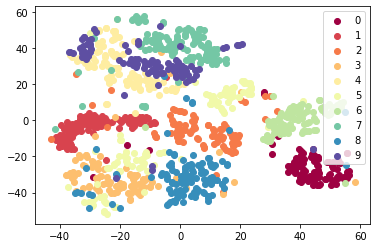

In [33]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y = tsne_s2(X, pre=0.1, appr=1, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Compute joint P for 0 points
Mean value of sigma: 3.498605
-----pairwise similarity done. It costs 0.045297 seconds-----
Stage 1's Iteration 100: error is 7.897707
Stage 1's Iteration 200: error is 7.829446
Stage 1's Iteration 300: error is 0.942886
Stage 1's Iteration 400: error is 0.774692
Stage 1's Iteration 500: error is 0.568241
Stage 1's Iteration 600: error is 0.484451
Stage 1's Iteration 700: error is 0.470640
Stage 1's Iteration 800: error is 0.470006
Stage 1's Iteration 900: error is 0.468690
Stage 1's Iteration 1000: error is 0.468171
Stage 1's Early stopping at iteration 1030, the final error is 0.4679573080984646
-----Gradient descent done. It costs 1.725551 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
-----pairwise similarity done. It costs 0.574878 seconds.-----
Stage 2's Iteration 100: error is 8.533906
Stage 2's Iteration 200: error is 9.742490
Stage 2's Iteration 300: error 

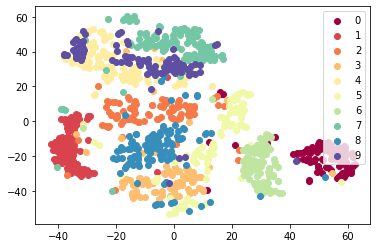

In [34]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y = tsne_s2(X, pre=0.1, appr=3, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Compute joint P for 0 points
Mean value of sigma: 3.498605
-----pairwise similarity done. It costs 0.046506 seconds-----
Stage 1's Iteration 100: error is 7.897707
Stage 1's Iteration 200: error is 7.829446
Stage 1's Iteration 300: error is 0.942886
Stage 1's Iteration 400: error is 0.774692
Stage 1's Iteration 500: error is 0.568241
Stage 1's Iteration 600: error is 0.484451
Stage 1's Iteration 700: error is 0.470640
Stage 1's Iteration 800: error is 0.470006
Stage 1's Iteration 900: error is 0.468690
Stage 1's Iteration 1000: error is 0.468171
Stage 1's Early stopping at iteration 1030, the final error is 0.4679573080984646
-----Gradient descent done. It costs 1.793522 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
-----pairwise similarity done. It costs 0.584820 seconds.-----
Stage 2's Iteration 100: error is 8.561791
Stage 2's Iteration 200: error is 9.882786
Stage 2's Iteration 300: error 

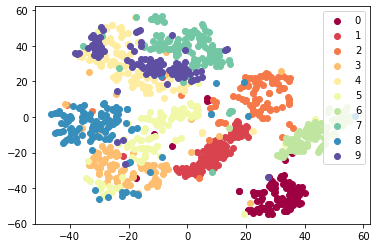

In [35]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y = tsne_s2(X, pre=0.1, appr=5, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Compute joint P for 0 points
Mean value of sigma: 3.498605
-----pairwise similarity done. It costs 0.046562 seconds-----
Stage 1's Iteration 100: error is 7.897707
Stage 1's Iteration 200: error is 7.829446
Stage 1's Iteration 300: error is 0.942886
Stage 1's Iteration 400: error is 0.774692
Stage 1's Iteration 500: error is 0.568241
Stage 1's Iteration 600: error is 0.484451
Stage 1's Iteration 700: error is 0.470640
Stage 1's Iteration 800: error is 0.470006
Stage 1's Iteration 900: error is 0.468690
Stage 1's Iteration 1000: error is 0.468171
Stage 1's Early stopping at iteration 1030, the final error is 0.4679573080984646
-----Gradient descent done. It costs 1.771359 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
-----pairwise similarity done. It costs 0.584007 seconds.-----
Stage 2's Iteration 100: error is 8.669475
Stage 2's Iteration 200: error is 9.833695
Stage 2's Iteration 300: error 

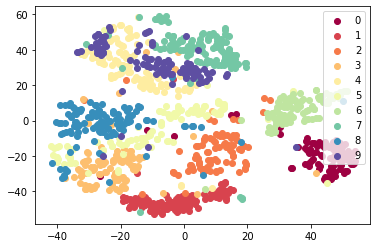

In [36]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y = tsne_s2(X, pre=0.1, appr=8, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Compute joint P for 0 points
Mean value of sigma: 3.498605
-----pairwise similarity done. It costs 0.047147 seconds-----
Stage 1's Iteration 100: error is 7.897707
Stage 1's Iteration 200: error is 7.829446
Stage 1's Iteration 300: error is 0.942886
Stage 1's Iteration 400: error is 0.774692
Stage 1's Iteration 500: error is 0.568241
Stage 1's Iteration 600: error is 0.484451
Stage 1's Iteration 700: error is 0.470640
Stage 1's Iteration 800: error is 0.470006
Stage 1's Iteration 900: error is 0.468690
Stage 1's Iteration 1000: error is 0.468171
Stage 1's Early stopping at iteration 1030, the final error is 0.4679573080984646
-----Gradient descent done. It costs 1.805141 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
-----pairwise similarity done. It costs 0.587083 seconds.-----
Stage 2's Iteration 100: error is 9.026947
Stage 2's Iteration 200: error is 9.818567
Stage 2's Iteration 300: error 

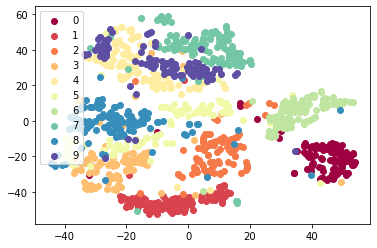

In [37]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y = tsne_s2(X, pre=0.1, appr=15, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Compute joint P for 0 points
Mean value of sigma: 3.498605
-----pairwise similarity done. It costs 0.045103 seconds-----
Stage 1's Iteration 100: error is 7.897707
Stage 1's Iteration 200: error is 7.829446
Stage 1's Iteration 300: error is 0.942886
Stage 1's Iteration 400: error is 0.774692
Stage 1's Iteration 500: error is 0.568241
Stage 1's Iteration 600: error is 0.484451
Stage 1's Iteration 700: error is 0.470640
Stage 1's Iteration 800: error is 0.470006
Stage 1's Iteration 900: error is 0.468690
Stage 1's Iteration 1000: error is 0.468171
Stage 1's Early stopping at iteration 1030, the final error is 0.4679573080984646
-----Gradient descent done. It costs 1.713609 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
-----pairwise similarity done. It costs 0.576340 seconds.-----
Stage 2's Iteration 100: error is 9.841895
Stage 2's Iteration 200: error is 9.846565
Stage 2's Iteration 300: error 

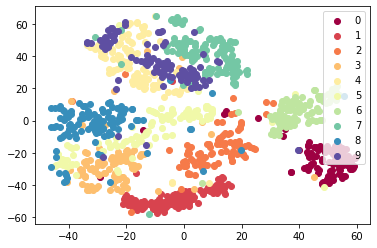

In [38]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y = tsne_s2(X, pre=0.1, appr=25, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Compute joint P for 0 points
Mean value of sigma: 3.498605
-----pairwise similarity done. It costs 0.044831 seconds-----
Stage 1's Iteration 100: error is 7.897707
Stage 1's Iteration 200: error is 7.829446
Stage 1's Iteration 300: error is 0.942886
Stage 1's Iteration 400: error is 0.774692
Stage 1's Iteration 500: error is 0.568241
Stage 1's Iteration 600: error is 0.484451
Stage 1's Iteration 700: error is 0.470640
Stage 1's Iteration 800: error is 0.470006
Stage 1's Iteration 900: error is 0.468690
Stage 1's Iteration 1000: error is 0.468171
Stage 1's Early stopping at iteration 1030, the final error is 0.4679573080984646
-----Gradient descent done. It costs 1.757343 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
-----pairwise similarity done. It costs 0.566013 seconds.-----
Stage 2's Iteration 100: error is 9.793478
Stage 2's Iteration 200: error is 9.815573
Stage 2's Iteration 300: error 

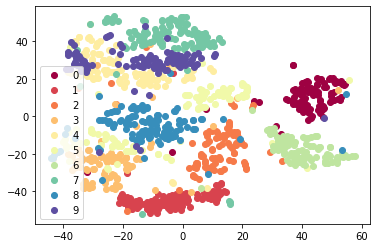

In [39]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y = tsne_s2(X, pre=0.1, appr=50, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Compute joint P for 0 points
Mean value of sigma: 3.498605
-----pairwise similarity done. It costs 0.047533 seconds-----
Stage 1's Iteration 100: error is 7.897707
Stage 1's Iteration 200: error is 7.829446
Stage 1's Iteration 300: error is 0.942886
Stage 1's Iteration 400: error is 0.774692
Stage 1's Iteration 500: error is 0.568241
Stage 1's Iteration 600: error is 0.484451
Stage 1's Iteration 700: error is 0.470640
Stage 1's Iteration 800: error is 0.470006
Stage 1's Iteration 900: error is 0.468690
Stage 1's Iteration 1000: error is 0.468171
Stage 1's Early stopping at iteration 1030, the final error is 0.4679573080984646
-----Gradient descent done. It costs 1.710795 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
-----pairwise similarity done. It costs 0.560715 seconds.-----
Stage 2's Iteration 100: error is 9.857021
Stage 2's Iteration 200: error is 9.782684
Stage 2's Iteration 300: error 

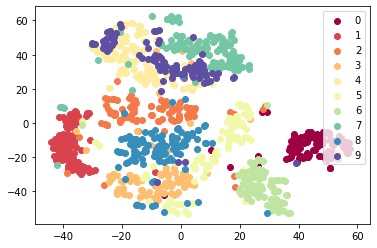

In [40]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y = tsne_s2(X, pre=0.1, appr=75, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Compute joint P for 0 points
Mean value of sigma: 3.498605
-----pairwise similarity done. It costs 0.044436 seconds-----
Stage 1's Iteration 100: error is 7.897707
Stage 1's Iteration 200: error is 7.829446
Stage 1's Iteration 300: error is 0.942886
Stage 1's Iteration 400: error is 0.774692
Stage 1's Iteration 500: error is 0.568241
Stage 1's Iteration 600: error is 0.484451
Stage 1's Iteration 700: error is 0.470640
Stage 1's Iteration 800: error is 0.470006
Stage 1's Iteration 900: error is 0.468690
Stage 1's Iteration 1000: error is 0.468171
Stage 1's Early stopping at iteration 1030, the final error is 0.4679573080984646
-----Gradient descent done. It costs 1.728187 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
-----pairwise similarity done. It costs 0.570680 seconds.-----
Stage 2's Iteration 100: error is 9.808534
Stage 2's Iteration 200: error is 9.812619
Stage 2's Iteration 300: error 

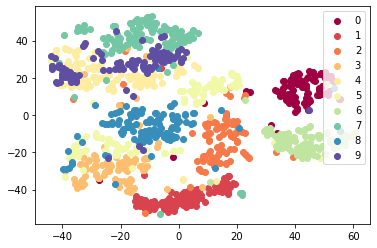

In [41]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y = tsne_s2(X, pre=0.1, appr=100, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Compute joint P for 0 points
Mean value of sigma: 4.403753
-----pairwise similarity done. It costs 0.022059 seconds-----
Stage 1's Iteration 100: error is 7.423385
Stage 1's Iteration 200: error is 6.973233
Stage 1's Early stopping at iteration 200, the final error is 6.84996849278116
-----Gradient descent done. It costs 0.142415 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
-----pairwise similarity done. It costs 0.563270 seconds.-----
Stage 2's Iteration 100: error is 9.725448
Stage 2's Iteration 200: error is 9.725385
Stage 2's Iteration 300: error is 0.921339
Stage 2's Iteration 400: error is 0.878497
Stage 2's Iteration 500: error is 0.868192
Stage 2's Iteration 600: error is 0.863875
Stage 2's Early stopping at iteration 647, the final error is 0.8627104473054464
-----Gradient descent done. It costs 41.035711 seconds.-----
time:42.18264675140381


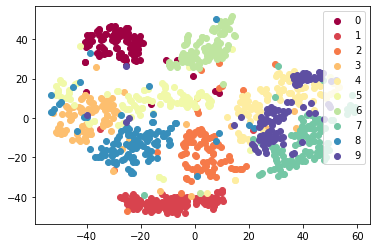

In [20]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y,Y1 = tsne_s2(X, pre=0.05, appr=8, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Compute joint P for 0 points
Mean value of sigma: 3.083338
-----pairwise similarity done. It costs 0.096750 seconds-----
Stage 1's Iteration 100: error is 8.549645
Stage 1's Iteration 200: error is 8.800275
Stage 1's Iteration 300: error is 0.533035
Stage 1's Iteration 400: error is 0.505924
Stage 1's Iteration 500: error is 0.505697
Stage 1's Iteration 600: error is 0.505573
Stage 1's Iteration 700: error is 0.504619
Stage 1's Iteration 800: error is 0.504616
Stage 1's Early stopping at iteration 834, the final error is 0.5046159027916907
-----Gradient descent done. It costs 3.256366 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
-----pairwise similarity done. It costs 0.585042 seconds.-----
Stage 2's Iteration 100: error is 9.721676
Stage 2's Iteration 200: error is 9.725274
Stage 2's Iteration 300: error is 0.922287
Stage 2's Iteration 400: error is 0.878603
Stage 2's Iteration 500: error is

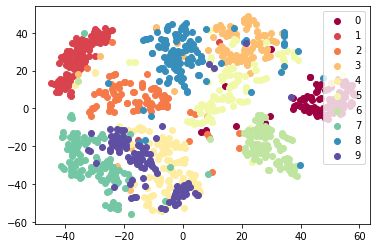

In [21]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y,Y1 = tsne_s2(X, pre=0.2, appr=8, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Compute joint P for 0 points
Mean value of sigma: 2.936872
-----pairwise similarity done. It costs 0.147287 seconds-----
Stage 1's Iteration 100: error is 8.427375
Stage 1's Iteration 200: error is 8.478856
Stage 1's Iteration 300: error is 0.580290
Stage 1's Iteration 400: error is 0.576110
Stage 1's Iteration 500: error is 0.575311
Stage 1's Iteration 600: error is 0.575005
Stage 1's Early stopping at iteration 624, the final error is 0.5749584936970848
-----Gradient descent done. It costs 4.310309 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
-----pairwise similarity done. It costs 0.575260 seconds.-----
Stage 2's Iteration 100: error is 8.465676
Stage 2's Iteration 200: error is 9.774298
Stage 2's Iteration 300: error is 0.921352
Stage 2's Iteration 400: error is 0.878665
Stage 2's Iteration 500: error is 0.868304
Stage 2's Iteration 600: error is 0.864300
Stage 2's Early stopping at itera

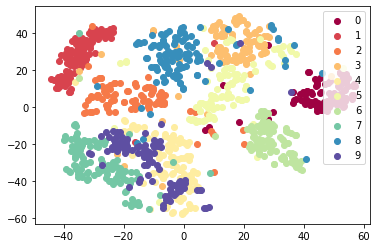

In [22]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y,Y1 = tsne_s2(X, pre=0.3, appr=8, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Compute joint P for 0 points
Mean value of sigma: 2.765136
-----pairwise similarity done. It costs 0.253265 seconds-----
Stage 1's Iteration 100: error is 9.146546
Stage 1's Iteration 200: error is 9.142571
Stage 1's Iteration 300: error is 0.709754
Stage 1's Iteration 400: error is 0.697887
Stage 1's Iteration 500: error is 0.695459
Stage 1's Iteration 600: error is 0.694471
Stage 1's Iteration 700: error is 0.693932
Stage 1's Early stopping at iteration 743, the final error is 0.6937588777987592
-----Gradient descent done. It costs 13.649541 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
-----pairwise similarity done. It costs 0.565503 seconds.-----
Stage 2's Iteration 100: error is 8.467231
Stage 2's Iteration 200: error is 8.593723
Stage 2's Iteration 300: error is 0.930307
Stage 2's Iteration 400: error is 0.886825
Stage 2's Iteration 500: error is 0.875823
Stage 2's Iteration 600: error i

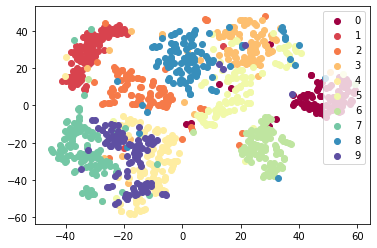

In [23]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y,Y1 = tsne_s2(X, pre=0.5, appr=8, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

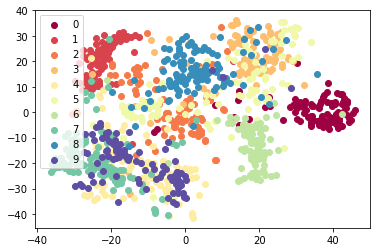

In [24]:
draw_pic(Y1, labels, name = "final.jpg")


# Result

In [16]:
# use 1000 lines for test
np.random.seed(22)

subset = data.sample(10000)
# subset = data
print(subset['label'].value_counts())

1    1143
7    1078
8    1020
9    1015
2     983
0     982
3     977
4     960
6     945
5     897
Name: label, dtype: int64


In [17]:
t1 = time.time()
# interpolation
np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y,Y_init = tsne_s2(X, pre=0.1, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)


print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.511528
-----pairwise similarity done. It costs 0.596894 seconds-----
Stage 1's Iteration 100: error is 9.712332
Stage 1's Iteration 200: error is 9.711875
Stage 1's Iteration 300: error is 0.921671
Stage 1's Iteration 400: error is 0.878122
Stage 1's Iteration 500: error is 0.867626
Stage 1's Iteration 600: error is 0.863564
Stage 1's Iteration 700: error is 0.861444
Stage 1's Iteration 800: error is 0.860137
Stage 1's Iteration 900: error is 0.859244
Stage 1's Iteration 1000: error is 0.858585
Stage 1's Early stopping at iteration 1019, the final error is 0.8584727039344582
-----Gradient descent done. It costs 63.559909 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Compute joint P for 1000 points
Compute joint P for 1500 points
Compute joint P for 2000 points
Compute joint P for 2500 points
Compute joint P for 3000 points
Compute joint P fo

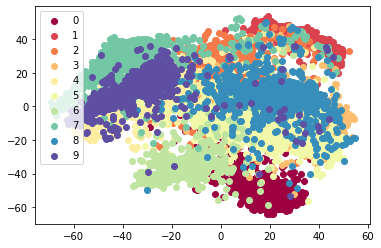

In [18]:
draw_pic(Y_init, labels, name = "init_layout.jpg")

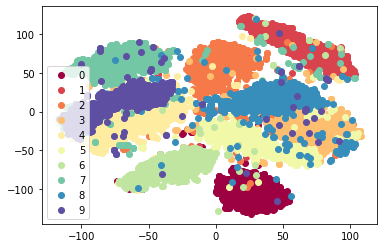

In [19]:
draw_pic(Y, labels, name = "final.jpg")

In [22]:
t2 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

Y,Y_init = tsne_s3(X, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)

print('time:{}'.format(time.time()-t2))

Preprocessing the data using PCA...
Preprocessing the data using PCA...
Compute joint P for 0 points
Compute joint P for 500 points
Compute joint P for 1000 points
Compute joint P for 1500 points
Compute joint P for 2000 points
Compute joint P for 2500 points
Compute joint P for 3000 points
Compute joint P for 3500 points
Compute joint P for 4000 points
Compute joint P for 4500 points
Compute joint P for 5000 points
Compute joint P for 5500 points
Compute joint P for 6000 points
Compute joint P for 6500 points
Compute joint P for 7000 points
Compute joint P for 7500 points
Compute joint P for 8000 points
Compute joint P for 8500 points
Compute joint P for 9000 points
Compute joint P for 9500 points
Mean value of sigma: 1.832269
-----pairwise similarity done. It costs 15.983940 seconds.-----
Stage 2's Iteration 100: error is 12.890742
Stage 2's Iteration 200: error is 12.359414
Stage 2's Iteration 300: error is 2.246709
Stage 2's Iteration 400: error is 1.993721
Stage 2's Iteration 500:

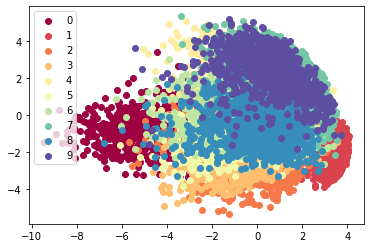

In [23]:
draw_pic(Y_init, labels, name = "final.jpg")

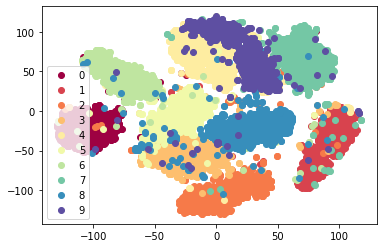

In [24]:
draw_pic(Y, labels, name = "final.jpg")

Preprocessing the data using PCA...
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.511528
-----pairwise similarity done. It costs 0.571000 seconds-----
Stage 1's Iteration 100: error is 9.712332
Stage 1's Iteration 200: error is 9.711875
Stage 1's Iteration 300: error is 0.921671
Stage 1's Iteration 400: error is 0.878122
Stage 1's Iteration 500: error is 0.867626
Stage 1's Iteration 600: error is 0.863564
Stage 1's Iteration 700: error is 0.861444
Stage 1's Iteration 800: error is 0.860137
Stage 1's Iteration 900: error is 0.859244
Stage 1's Iteration 1000: error is 0.858585
Stage 1's Early stopping at iteration 1019, the final error is 0.8584727039344582
-----Gradient descent done. It costs 69.774273 seconds.-----
Compute joint P for 0 points
Compute joint P for 500 points
Compute joint P for 1000 points
Compute joint P for 1500 points
Compute joint P for 2000 points
Compute joint P for 2500 points
Compute joint P for 3000 points
Compute joint P fo

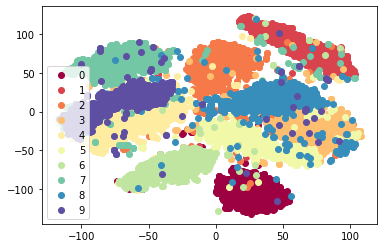

In [29]:
t1 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])
# 200 tol
Y = tsne_s2(X, pre=0.1, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t1))

Preprocessing the data using PCA...
Preprocessing the data using PCA...
Compute joint P for 0 points
Compute joint P for 500 points
Compute joint P for 1000 points
Compute joint P for 1500 points
Compute joint P for 2000 points
Compute joint P for 2500 points
Compute joint P for 3000 points
Compute joint P for 3500 points
Compute joint P for 4000 points
Compute joint P for 4500 points
Compute joint P for 5000 points
Compute joint P for 5500 points
Compute joint P for 6000 points
Compute joint P for 6500 points
Compute joint P for 7000 points
Compute joint P for 7500 points
Compute joint P for 8000 points
Compute joint P for 8500 points
Compute joint P for 9000 points
Compute joint P for 9500 points
Mean value of sigma: 1.832269
-----pairwise similarity done. It costs 16.242701 seconds.-----
Stage 2's Iteration 100: error is 12.890742
Stage 2's Iteration 200: error is 12.359414
Stage 2's Iteration 300: error is 2.246709
Stage 2's Iteration 400: error is 1.993721
Stage 2's Iteration 500:

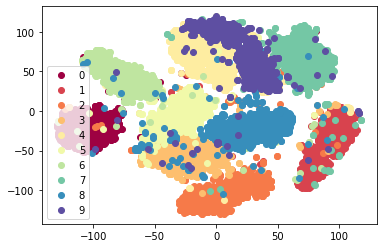

In [14]:
t2 = time.time()

np.random.seed(22)

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

Y = tsne_s3(X, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=3, tolerance=1e-4, max_iter=2500)
draw_pic(Y, labels, name = "final.jpg")

print('time:{}'.format(time.time()-t2))

# previous outputs

Preprocessing the data using PCA...
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
Iteration 100: error is 15.759533
Iteration 200: error is 15.780718
Iteration 300: error is 0.939492
Iteration 400: error is 0.893789
Iteration 500: error is 0.883162
Iteration 600: error is 0.878906
Iteration 700: error is 0.876449
Iteration 800: error is 0.875061
Iteration 900: error is 0.874132
Iteration 1000: error is 0.873456
t-SNE done! Time elapsed: 138.72323417663574 seconds


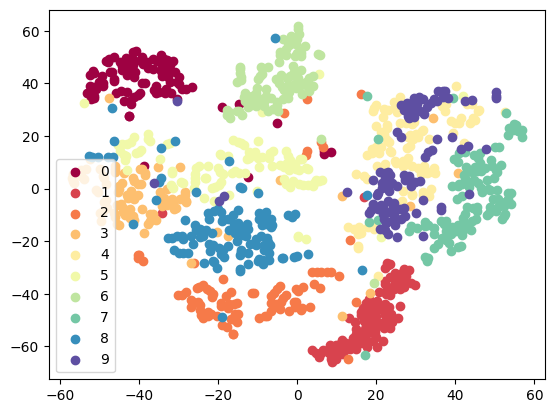

In [ ]:
time_start = time.time()

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

Y = tsne(X, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, max_iter=1000) # 1000

draw_pic(Y, labels, name = "final.jpg")
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Preprocessing the data using PCA...
Compute joint P for 0 points
Compute joint P for 500 points
Compute joint P for 1000 points
Compute joint P for 1500 points
Compute joint P for 2000 points
Compute joint P for 2500 points
Compute joint P for 3000 points
Mean value of sigma: 2.104070
Iteration 50: error is 17.474752
Iteration 100: error is 17.104185
Iteration 150: error is 1.860589
Iteration 200: error is 1.574273
Iteration 250: error is 1.442264
Iteration 300: error is 1.368554
Iteration 350: error is 1.321939
Iteration 400: error is 1.289742
Iteration 450: error is 1.266464
Iteration 500: error is 1.249030
Iteration 550: error is 1.235546
Iteration 600: error is 1.224906
Iteration 650: error is 1.216301
Iteration 700: error is 1.209230
Iteration 750: error is 1.203434
Iteration 800: error is 1.198554
Iteration 850: error is 1.194404
Iteration 900: error is 1.190831
Iteration 950: error is 1.187763
Iteration 1000: error is 1.185107
t-SNE done! Time elapsed: 979.250629901886 seconds


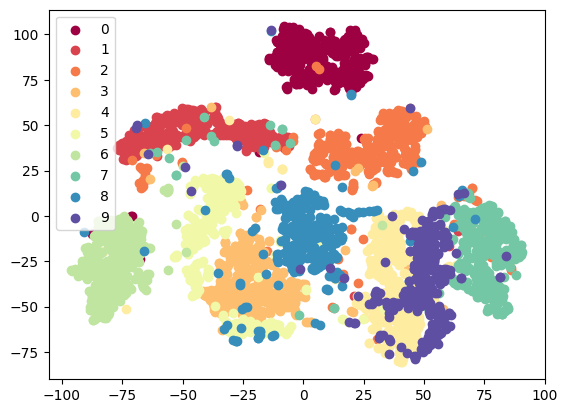

In [ ]:
time_start = time.time()

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

Y = tsne(X, 2, 50, 30.0)

draw_pic(Y, labels, name = "final.jpg")
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Compute joint P for 0 points
Compute joint P for 500 points
Compute joint P for 1000 points
Compute joint P for 1500 points
Compute joint P for 2000 points
Compute joint P for 2500 points
Compute joint P for 3000 points
Compute joint P for 3500 points
Compute joint P for 4000 points
Compute joint P for 4500 points
Compute joint P for 5000 points
Compute joint P for 5500 points
Compute joint P for 6000 points
Compute joint P for 6500 points
Mean value of sigma: 2.118568
Preprocessing the data using PCA...
Iteration 50: error is 20.045892
Iteration 100: error is 18.785540
Iteration 150: error is 2.430358
Iteration 200: error is 2.112669
Iteration 250: error is 1.941719
Iteration 300: error is 1.832407
Iteration 350: error is 1.755587
Iteration 400: error is 1.699409
Iteration 450: error is 1.656398
Iteration 500: error is 1.622505
Iteration 550: error is 1.595260
Iteration 600: error is 1.572933
Iteration 650: error is 1.554441
Iteration 700: error is 1.538773
Iteration 750: error is 1.5

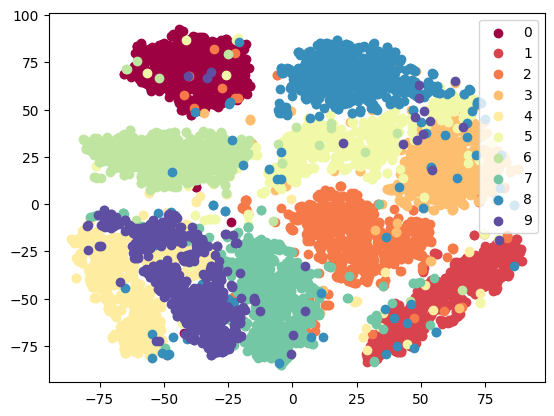

In [ ]:
time_start = time.time()

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

Y = tsne(X, 2, 50, 30.0)

draw_pic(Y, labels, name = "final.jpg")
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))